In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp
import numpy as np
from jax import grad, vmap, jit, jacfwd, jacrev, value_and_grad
from functools import partial
from jax.flatten_util import ravel_pytree
import jax.random as random
from jax.lax import cond, scan
import jax.example_libraries.optimizers as optimizers
key = random.PRNGKey(2022)

from utils_node import init_params_damage, init_params_damage_simple
from utils_node import RK_forward_pass_nobias as NODE_nobias, RK_forward_pass as NODE

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
import pickle


from diffrax import diffeqsolve, ODETerm, SaveAt#, Heun as mysolver
from diffrax import Dopri5, Dopri8, Heun, Tsit5, Kvaerno3, Kvaerno4, Kvaerno5
from diffrax import PIDController

mysolver = Heun

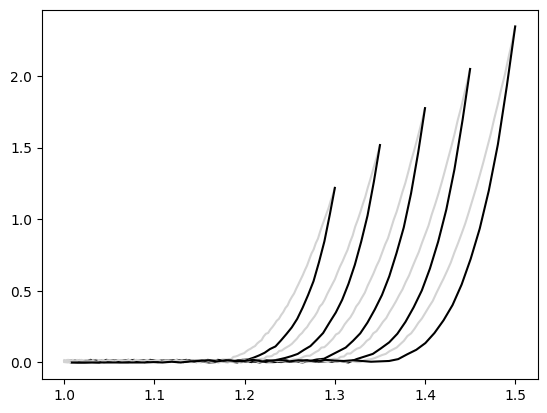

In [2]:
specimen = 'PA_Belly_Dermis1'

metadata = pd.read_csv('data/Dermis/DamageData.csv')
width = float(metadata[metadata.Specimen == specimen]['Width'])
thickness = float(metadata[metadata.Specimen == specimen]['Thickness'])
A = width*thickness # Cross sectional area


data = pd.read_csv('data/Dermis/DamageData/' + specimen + 'Data.csv')
def extract_numbers_and_cycle(value):
    parts = value.split('-')
    number = int(parts[0])
    cycle = parts[1] if len(parts) > 1 else None
    return pd.Series({'#': number, 'Cycle': cycle})

#Extract the unloaded length so we can find the stretches
data2 = data[data.Cycle != '1-Preload']
L0 = np.min(data2['Size_mm'])


"""
Currently the data has a column similar to 2-Recover, where the "2" indicates
the cycle number and "Recover" the stage of loading within that cycle. 
Change this so that the column "Cycle" only contains the cycle number, say, "2"
and add a new column called "Type" that contains the stage of loading.
"""
data[['#', 'Cycle']] = data['Cycle'].apply(extract_numbers_and_cycle)
data = data[['SetName', '#', 'Cycle', 'Time_S', 'Size_mm', 'Displacement_mm', 'Force_N']]
data = data.rename(columns={'Cycle': 'Type', '#': 'Cycle'})


"""
The specimen is loaded to each lmb_max 5 times. In theory all the curves after 
the first should overlap, since the maximum amount of deformation hasn't 
increased. But the stress curves still keep decreasing. Our current formulation
of damage cannot account for this, so only keep the last cycle.
"""
data = data[data.Cycle==5]
setnames = np.unique(data['SetName'])
data_l = data[data.Type == 'Stretch']
l = np.min([len(data_l[data_l['SetName']==setname]) for setname in setnames])
# Collect the relevant variables in numpy arrays
time_l_gt = []
disp_l_gt = []
sgmx_l_gt = []
for setname in setnames:
    time_l_gt.append(data_l[data_l['SetName']==setname]['Time_S'][:l])
    disp_l_gt.append(data_l[data_l['SetName']==setname]['Displacement_mm'][:l])
    sgmx_l_gt.append(data_l[data_l['SetName']==setname]['Force_N'][:l]/A)
time_l_gt = np.array(time_l_gt)
disp_l_gt = np.array(disp_l_gt)
sgmx_l_gt = np.array(sgmx_l_gt)
lmbx_l_gt = 1.0+disp_l_gt/L0



data_u = data[data.Type == 'Recover']
l = np.min([len(data_u[data_u['SetName']==setname]) for setname in setnames]) #get the minimum length of data_u so we have a common length
# Collect the relevant variables in numpy arrays
time_u_gt = []
disp_u_gt = []
sgmx_u_gt = []
for setname in setnames:
    time_u_gt.append(data_u[data_u['SetName']==setname]['Time_S'][:l])
    disp_u_gt.append(np.flip(data_u[data_u['SetName']==setname]['Displacement_mm'][:l]))
    sgmx_u_gt.append(np.flip(data_u[data_u['SetName']==setname]['Force_N'][:l]/A))
time_u_gt = np.array(time_u_gt)
disp_u_gt = np.array(disp_u_gt)
sgmx_u_gt = np.array(sgmx_u_gt)
lmbx_u_gt = 1.0+disp_u_gt/L0


# # Get rid of the jumps in time
# t0 = 0.0
# for i in range(len(time_u_gt)):
#     time_u_gt[i] = time_u_gt[i] - time_u_gt[i][0] + t0
#     t0 = time_u_gt[i][-1]


n_cycles = len(time_u_gt)
for i in range(n_cycles):
    plt.plot(lmbx_l_gt[i], sgmx_l_gt[i], 'lightgray')
    plt.plot(lmbx_u_gt[i], sgmx_u_gt[i], 'k-')

n_damage = 4

In [75]:
#Psi functions
def Psi1_fn(params, I1):
    params, bias = params
    return NODE_nobias(I1-3, params) + jnp.exp(bias)
def Psi2_fn(params, I2):
    params, bias = params
    return NODE_nobias(I2-3, params) + jnp.exp(bias)
def Psiv_fn(params, Iv):
    params, theta = params
    Psiv = NODE_nobias(Iv-1, params)
    return jnp.maximum(Psiv, 0.0)
def Psiw_fn(params, Iw):
    params, theta = params
    Psiw = NODE_nobias(Iw-1, params)
    return jnp.maximum(Psiw, 0.0)
Psi_fns = (Psi1_fn, Psi2_fn, Psiv_fn, Psiw_fn)

def f(d, params):
    return 1.0-d
f_vmap = vmap(f, in_axes=(0, None))
def G(tau, params):
    tau = tau/500.0 #divide by 500 for normalization
    params, a = params
    # tau = jnp.log(tau)/10.0 # normalization
    # return NODE_nobias(tau, params)
    return jnp.tanh(jnp.exp(a)*NODE_nobias(tau, params))
G_vmap = vmap(G, in_axes=(0, None))

In [76]:
# These functions are needed for predictions under realistic loading cases
def eval_Cauchy_singlevar(lmbx, lmby, d, params):
    params_Psi1, params_G = params

    lmbz = 1.0/(lmbx*lmby)
    F = jnp.array([[lmbx, 0, 0],
                   [0, lmby, 0],
                   [0, 0, lmbz]])
    C = F.T @ F
    Cinv = jnp.linalg.inv(C)

    I1 = C[0,0] + C[1,1] + C[2,2]

    f1 = jnp.clip(1.0-d, a_min=0.0, a_max=1.0)
    Psi1 = jnp.exp(Psi1_fn(params_Psi1, I1))

    p = -C[2,2]*(2*Psi1)
    S = p*Cinv + 2*Psi1*jnp.eye(3) # do (1-d)* the usual S
    S = f1*S

    sgm = F @ (S @ F.T)
    return sgm
eval_Cauchy_vmap = vmap(eval_Cauchy_singlevar, in_axes=(0,0,0,None), out_axes = 0)
eval_Cauchy_vmap2 = vmap(eval_Cauchy_singlevar, in_axes=(0,0,None,None), out_axes = 0)

In [77]:
@partial(jit, static_argnums=(3,))
def ddot_singlevar(params_G, y, taudot, ddot_fn):
    """
    Difference between this function and, say, ddot_vahid: 
    1. This function checks for damage criterion.
    2. This function returns both ddot and rdot

    Differences from the ddot_fn in the other notebooks:
    1. It works with only 1 damage function (Psi_I1)
    2. It assumes f=1-d
    """
    d, r, tau = y

    #check if g<0
    g = G(tau, params_G) - G(r, params_G)
    def true_fun(): #What to return for rdot & ddot if g<0
        return 0.0, 0.0, taudot
    def false_fun():
        ddot = ddot_fn(params_G, tau, taudot)
        rdot = taudot
        return ddot, rdot, taudot
    ydot = cond(g<0, true_fun, false_fun)
    return jnp.stack(ydot)

def Psi1_uniaxial(t, params_Psi, lmb_dot):
    lmbx = 1.0 + lmb_dot*t
    I1 = lmbx**2 + 2.0/lmbx # = lmbx**2 + lmby**2 + lmbz**2
    return Psi1_fn(params_Psi, I1)

def I1_fn(t, lmb_dot):
    lmbx = 1.0 + lmb_dot*t
    return lmbx**2 + 2.0/lmbx # = lmbx**2 + lmby**2 + lmbz**2

@partial(jit, static_argnums=(3,))
def integrate_d_uniax(params, lmb_max, y0, ddot_fn, saveat):
    params_Psi, params_G = params
    t_peak = 1.0
    lmb_dot = (lmb_max-1.0)/t_peak
    def yprime(t, y, args=None):
        I1, I1dot = value_and_grad(I1_fn)(t, lmb_dot)
        taudot = jnp.exp(Psi1_fn(params_Psi, I1))*I1dot
        return ddot_singlevar(params_G, y, taudot, ddot_fn)
    
    solution = diffeqsolve(terms=ODETerm(yprime), 
                           solver=Dopri5(), 
                           t0=0.0, 
                           t1=1.0, 
                           dt0=1.e-4, 
                           y0=y0, 
                           saveat=SaveAt(ts=saveat), 
                           max_steps=1048576)
    return solution.ys

# @partial(jit, static_argnums=(2,3,))
def repeat_uniax(params, lmb_max_list, ddot_fn, saveat):
    y0 = jnp.array([0.0,0.0,0.0]) # y0 = (d0, r0, tau0)

    # t and lmb are dummy vars, but it is convenient to return them from here
    t_list   = []
    lmb_list = []
    d_list   = []
    t0 = 0.0
    for i in range(len(lmb_max_list)):
        lmb_max = lmb_max_list[i]

        y = integrate_d_uniax(params, lmb_max, y0, ddot_fn, saveat)
        d_load   = y[:,0] #y consists of [r, d, tau], but we don't need to return r
        t0+= 1.0
        #Unloading curves
        t_unload   = t0 + saveat
        t0+= 1.0
        y0 = y[-1]
        y0 = y0.at[2].set(jnp.float64(0.0))

        t_list.append(t_unload)
        d_list.append(d_load)

    return jnp.array(t_list), jnp.array(lmb_list), jnp.clip(jnp.array(d_list), a_min=0.0, a_max=1.0)

@jit
def ddot_vahid(params_G, tau, taudot):
    ddot = taudot*grad(G)(tau, params_G)
    return ddot
ddot_vahid_vmap = vmap(ddot_vahid, in_axes=(None, 0, 0))

In [78]:
params = init_params_damage_simple(key, G_layers=[1,5,5,5,1])
lmbx_max_list = [np.max(x) for x in lmbx_u_gt]
saveat = jnp.linspace(0,1.0)
t, lmbx, d_pr = repeat_uniax(params, lmbx_max_list, ddot_vahid,saveat)

In [79]:
@partial(jit, static_argnums=(0,2,3,))
def step(loss, i, get_params, opt_update, opt_state):
    params = get_params(opt_state)
    g = grad(loss)(params)
    return opt_update(i, g, opt_state)

def train(loss, get_params, opt_update, opt_state, key, nIter = 10000, print_freq=1000, metric_fns=None):
    train_loss = []
    metrics = []
    for it in range(nIter):
        key, subkey = random.split(key)
        opt_state = step(loss, it, get_params, opt_update, opt_state)         
        if (it+1)% print_freq == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, metrics


lmbx_max_list = [np.max(x) for x in lmbx_u_gt]
def loss(params):
    saveat = jnp.linspace(0,1,2)
    t, lmbx, d_pr = repeat_uniax(params, lmbx_max_list, ddot_vahid, saveat)
    loss = []
    for i in range(5):
        di = d_pr[i]
        lmbx = lmbx_u_gt[i]
        lmby = 1.0/jnp.sqrt(lmbx)
        sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di[-1], params)[:,0,0]
        loss.append(jnp.mean((sgmx_u_gt[i]-sgmx_pr)**2))

    return jnp.mean(jnp.array(loss))

### Strategy 1: Train directly against stress data (doesn't work well)

In [8]:
params = init_params_damage_simple(key, Psi_layers=[1,3,3,3,1], G_layers=[1,5,5,5,1])
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

params, train_loss, _ = train(loss, get_params, opt_update, opt_state, key, nIter = 20000, print_freq=1000)

it 1000, train loss = 2.647062e-01
it 2000, train loss = 2.289590e-01
it 3000, train loss = 1.824340e-01
it 4000, train loss = 1.669759e-01
it 5000, train loss = 1.608701e-01
it 6000, train loss = 1.576964e-01
it 7000, train loss = 1.558783e-01
it 8000, train loss = 1.546284e-01
it 9000, train loss = 1.542735e-01
it 10000, train loss = 1.535645e-01
it 11000, train loss = 1.525832e-01
it 12000, train loss = 1.482910e-01
it 13000, train loss = 1.293395e-01
it 14000, train loss = 1.267223e-01
it 15000, train loss = 1.261115e-01
it 16000, train loss = 1.256101e-01
it 17000, train loss = 1.251266e-01
it 18000, train loss = 1.247665e-01
it 19000, train loss = 1.245024e-01
it 20000, train loss = 1.242981e-01


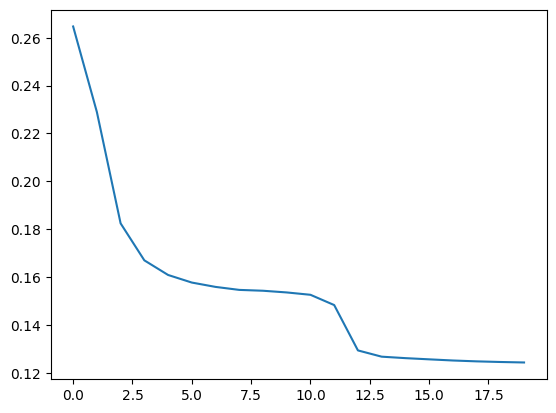

In [9]:
plt.plot(train_loss)

[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

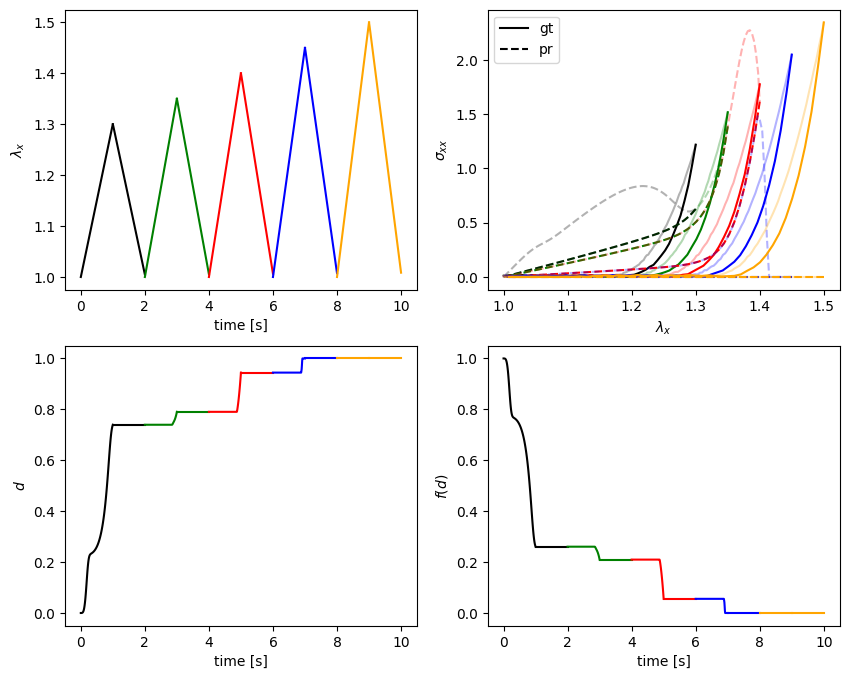

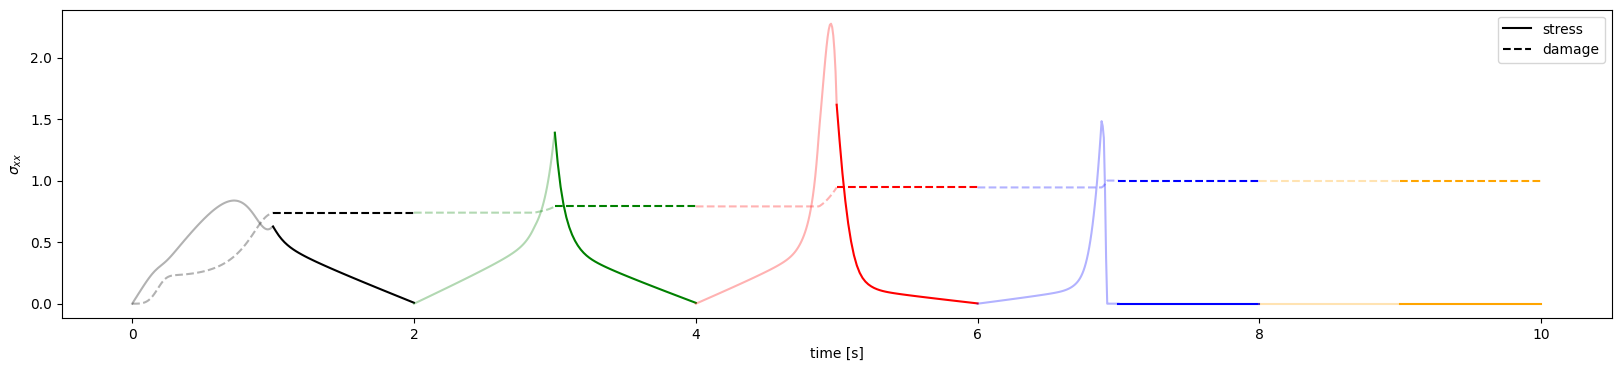

In [10]:
f_params = params[1]
saveat = np.linspace(0,1.0,lmbx_l_gt.shape[1])
t, _, d = repeat_uniax(params, lmbx_max_list, ddot_vahid, saveat)
d = np.array(d)
d = np.clip(d, a_min=0.0, a_max=1.0)
fig, ax = plt.subplots(2,2,figsize=(10,8))
fig, ax2 = plt.subplots(figsize=(20,4))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']

t0 = 0.0
for i in range(n_cycles):
    # Loading
    col = cols[i]
    di = d[i]
    lmbx_l = lmbx_l_gt[i]
    lmby_l = 1.0/np.sqrt(lmbx_l)
    time_l = t0 + np.linspace(0,1,lmbx_l.shape[0])
    sgmx_l = sgmx_l_gt[i]
    t0 += 1.0

    sgmx_l_pr = eval_Cauchy_vmap(lmbx_l, lmby_l, di, params)[:,0,0]

    ax[0,0].plot(time_l, lmbx_l, col)
    ax[0,1].plot(lmbx_l, sgmx_l_pr, col, linestyle='dashed', alpha=0.3)
    ax[0,1].plot(lmbx_l, sgmx_l, col, linestyle='solid', alpha=0.3)
    ax[1,0].plot(time_l, di, col)
    ax[1,1].plot(time_l, f_vmap(di, f_params), col)

    # ax[0,2].plot(time_l, sgmx_l, col, alpha=0.3)
    ax2.plot(time_l, sgmx_l_pr, col, alpha=0.3)
    ax2.plot(time_l, di, col, linestyle='dashed', alpha=0.3)

    # Unloading
    lmbx_u = np.flip(lmbx_u_gt[i])
    lmby_u = 1.0/np.sqrt(lmbx_u)
    time_u = t0 + np.linspace(0,1,lmbx_u.shape[0])
    t0 += 1
    sgmx_u = np.flip(sgmx_u_gt[i])
    sgmx_u_pr = eval_Cauchy_vmap2(lmbx_u, lmby_u, di[-1], params)[:,0,0]

    ax[0,0].plot(time_u, lmbx_u, col)
    ax[0,1].plot(lmbx_u, sgmx_u_pr, col, linestyle='dashed')
    ax[0,1].plot(lmbx_u, sgmx_u, col, linestyle='solid')
    ax[1,0].plot(time_u, di[-1]*np.ones_like(time_u), col)
    ax[1,1].plot(time_u, f_vmap(di[-1]*np.ones_like(time_u), f_params), col)

    ax2.plot(time_u, sgmx_u_pr, col)
    ax2.plot(time_u, di[-1]*np.ones_like(time_u), col, linestyle='dashed')

    sgmx_l = sgmx_l_gt[i]

ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')

legend_elements = [Line2D([0], [0], color='k', linestyle= '-', label='gt'),
                   Line2D([0], [0], color='k', linestyle='--', label='pr')]
ax[0,1].legend(handles=legend_elements)
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')

legend_elements = [Line2D([0], [0], color='k', linestyle= '-', label='stress'),
                   Line2D([0], [0], color='k', linestyle='--', label='damage')]
ax2.legend(handles=legend_elements)
ax2.set(xlabel='time [s]', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

### Strategy 2: Train just Psi_params + 5 damage parameters

In [80]:
def loss_Psi(params):
    d, params_Psi = params
    loss = []
    for i in range(len(lmbx_u_gt)):
        lmbx = lmbx_u_gt[i]
        lmby = 1.0/jnp.sqrt(lmbx)
        sgmx = sgmx_u_gt[i]
        di = jax.nn.sigmoid(d[i])
        sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di, (params_Psi, None))[:,0,0]
        loss.append(jnp.mean((sgmx-sgmx_pr)**2))
    return jnp.mean(jnp.array(loss))


params = init_params_damage_simple(key, Psi_layers=[1,3,3,3,1], G_layers=[1,5,5,5,1])
params_Psi = params[0]
d = np.linspace(0,0.8,5)
params = (d, params_Psi)
opt_init, opt_update, get_params = optimizers.adam(5.e-4) #Original: 1.e-4
opt_state = opt_init(params)

params, train_loss, _ = train(loss_Psi, get_params, opt_update, opt_state, key, nIter = 100000, print_freq=10000)
# min so far: 2.524991e-04: 5.e-4, 200k, Psi_layers=[1,3,3,3,1]

it 10000, train loss = 1.121702e-02
it 20000, train loss = 5.204323e-04
it 30000, train loss = 2.920508e-04
it 40000, train loss = 2.719141e-04
it 50000, train loss = 2.660218e-04
it 60000, train loss = 2.623921e-04
it 70000, train loss = 2.598360e-04
it 80000, train loss = 2.582557e-04
it 90000, train loss = 2.587077e-04
it 100000, train loss = 2.573336e-04


d =  [0.98018274 0.99460978 0.99850241 0.9995633  0.99985402]


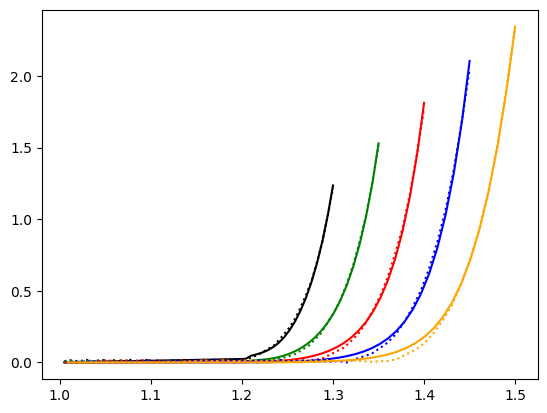

In [81]:
d_gt, params_Psi = params
d_gt = jax.nn.sigmoid(d_gt)
print('d = ', d_gt)
fig, ax = plt.subplots()
cols = ['black', 'green', 'red', 'blue', 'orange']

for i, di in enumerate(d_gt):
    lmbx = lmbx_u_gt[i]
    lmby = 1.0/jnp.sqrt(lmbx)
    sgmx = sgmx_u_gt[i]
    col = cols[i]
    sgmx_pr = eval_Cauchy_vmap2(lmbx, lmby, di, (params_Psi, None))[:,0,0]
    ax.plot(lmbx, sgmx_pr, col)
    ax.plot(lmbx, sgmx, col, linestyle=':')

Train params_G with these d values

In [82]:
# Task: integrate ddot_vahid_vmap from 0 to whatever Psi0 (tau) reaches in the first curve, and compare the value of d at the peak
saveat = [3.0]
for lmbx in lmbx_max_list:
    # get peak tau for each curve. To do this, we need to integrate Psi1_fn (i.e., dPsi/dI1)
    I1 = lmbx**2 + 2.0/lmbx
    saveat.append(I1)
saveat = jnp.array(saveat)
def yprime(I1, y, args=None): #The independent variable here is I1, not t.
    return jnp.exp(Psi1_fn(params_Psi, I1))

solution = diffeqsolve(terms=ODETerm(yprime), 
                       solver=Kvaerno5(), 
                       t0=saveat[0], 
                       t1=saveat[-1], 
                       dt0=1.e-5, 
                       y0=jnp.array([0.0]), 
                       saveat=SaveAt(ts=saveat),
                       max_steps=1048576,
                       stepsize_controller=PIDController(rtol=1e-9, atol=1e-9))
tau_gt = solution.ys.flatten()


def loss_d(params_G):
    d_pr = []
    for taui_gt in tau_gt[1:]:
        d_pr.append(G(taui_gt, params_G))
    d_pr = jnp.array(d_pr)
    return jnp.mean((d_gt-d_pr)**2)


params = init_params_damage_simple(key, Psi_layers=[1,3,3,3,1], G_layers=[1,5,5,5,1])
params_G = params[1]
opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(params_G)

params_G, train_loss, _ = train(loss_d, get_params, opt_update, opt_state, key, nIter = 15000000, print_freq=10000)
#last run: 4.401112e-10 with 5.e-5, [1,5,5,5,1], 3m

it 10000, train loss = 5.849455e-07
it 20000, train loss = 1.251721e-08
it 30000, train loss = 2.456660e-09
it 40000, train loss = 2.409282e-09
it 50000, train loss = 2.364515e-09
it 60000, train loss = 2.323474e-09
it 70000, train loss = 2.285825e-09
it 80000, train loss = 2.250896e-09
it 90000, train loss = 2.218466e-09
it 100000, train loss = 2.188217e-09
it 110000, train loss = 2.159853e-09
it 120000, train loss = 2.133224e-09
it 130000, train loss = 2.108108e-09
it 140000, train loss = 2.084366e-09
it 150000, train loss = 2.061962e-09
it 160000, train loss = 2.040361e-09
it 170000, train loss = 2.019890e-09
it 180000, train loss = 2.000336e-09
it 190000, train loss = 1.981535e-09
it 200000, train loss = 1.963487e-09
it 210000, train loss = 1.946060e-09
it 220000, train loss = 1.943087e-09
it 230000, train loss = 1.912808e-09
it 240000, train loss = 1.896864e-09
it 250000, train loss = 1.881260e-09
it 260000, train loss = 1.865979e-09
it 270000, train loss = 1.850937e-09
it 280000,

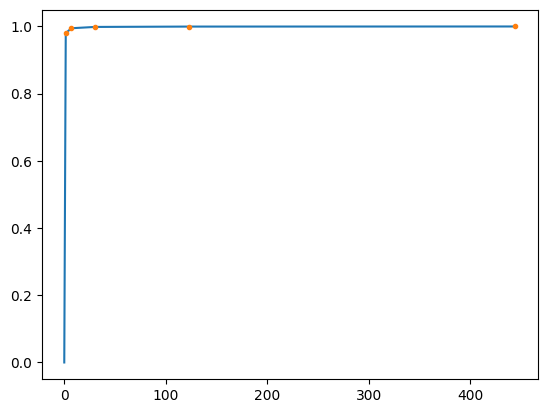

In [59]:
d_pr = []
for taui_gt in tau_gt:
    d_pr.append(G(taui_gt, params_G))
d_pr = jnp.array(d_pr)

plt.plot(tau_gt, d_pr)

temp = np.hstack([np.zeros(1), d_gt])
plt.plot(tau_gt[1:], d_gt, '.')

In [60]:
tau_gt

Array([  0.        ,   1.46071203,   7.00826479,  30.18195361,
       122.41755082, 444.0904984 ], dtype=float64, weak_type=True)

In [61]:
d_gt

Array([0.98018274, 0.99460978, 0.99850241, 0.9995633 , 0.99985402],      dtype=float64)

In [62]:
d_pr = []
for taui_gt in tau_gt[1:]:
    d_pr.append(G(taui_gt, params_G) - G(tau_gt[0], params_G))
d_pr = jnp.array(d_pr)

gt:  [0.98018274 0.99460978 0.99850241 0.9995633  0.99985402]
pr:  [0.98018272 0.99460991 0.99850226 0.99956226 0.99985622]


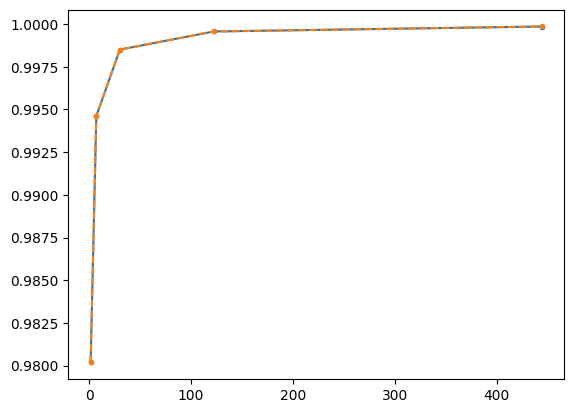

In [63]:
print('gt: ', d_gt)
print('pr: ', d_pr.flatten())

fig, ax = plt.subplots()
ax.plot(tau_gt[1:], d_gt, '.-')
ax.plot(tau_gt[1:], d_pr, '.--')

In [64]:
def integrate_d(params_G):
    def yprime(tau, d, args=None): # Here the independent variable is tau, the dependent variable is d
        # yprime = dd/dtau = dG/dtau (see ipad notes)
        return grad(G)(tau, params_G)
    
    solution = diffeqsolve(terms=ODETerm(yprime), 
                           solver=mysolver(), 
                           t0=tau_gt[0], 
                           t1=tau_gt[-1], 
                           dt0=0.001, 
                           y0=jnp.array([0.0]), 
                           saveat=SaveAt(ts=tau_gt),
                           max_steps=1048576)
    d_pr = solution.ys[1:]
    return d_pr

In [65]:
d_pr = integrate_d(params_G)
print('gt: ', d_gt)
print('pr: ', d_pr.flatten())

gt:  [0.98018274 0.99460978 0.99850241 0.9995633  0.99985402]
pr:  [0.98018271 0.99460991 0.99850226 0.99956226 0.99985622]


[Text(0.5, 0, 'time [s]'), Text(0, 0.5, '$f(d)$')]

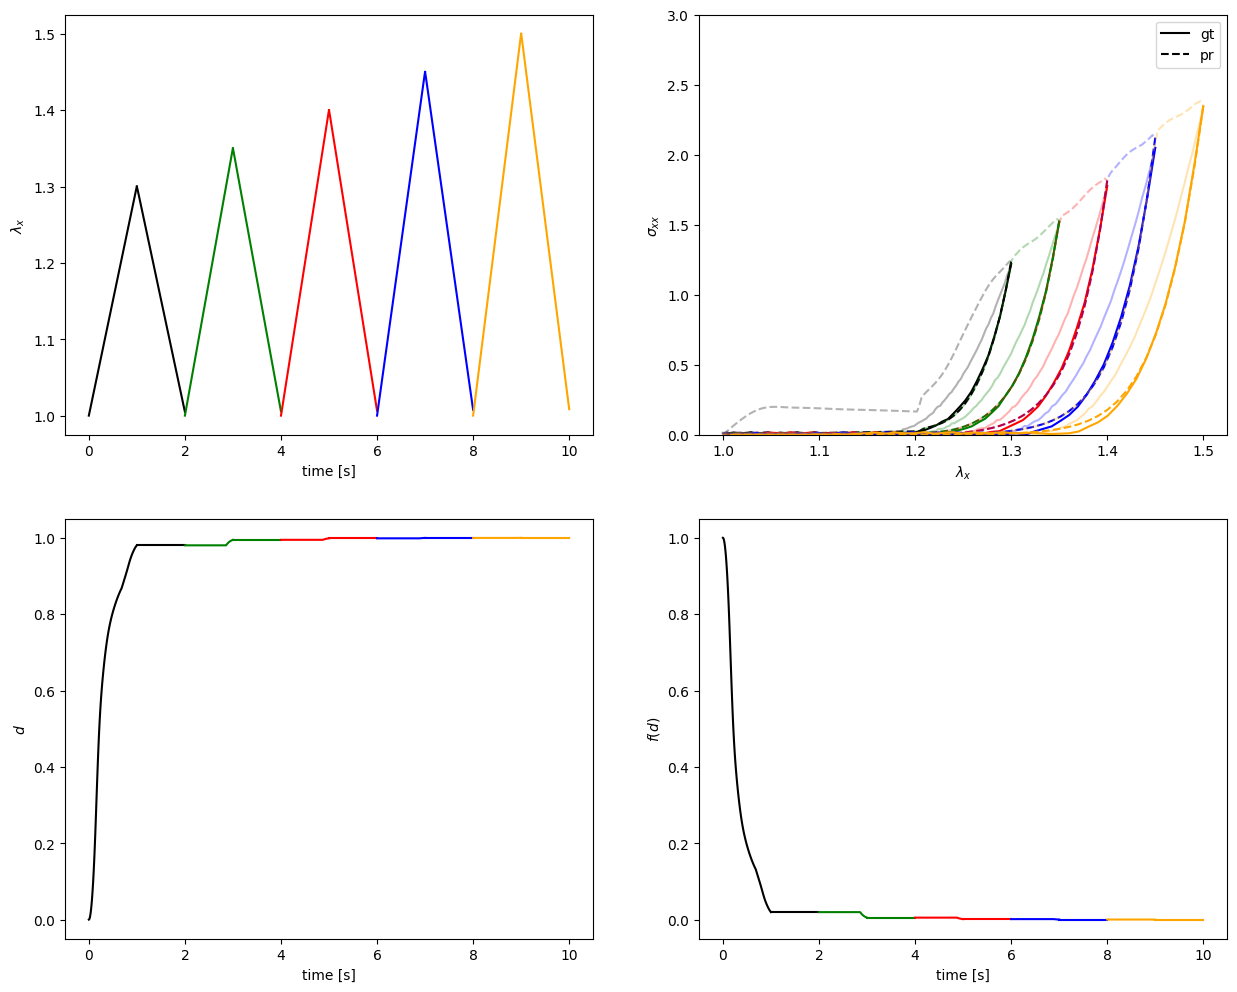

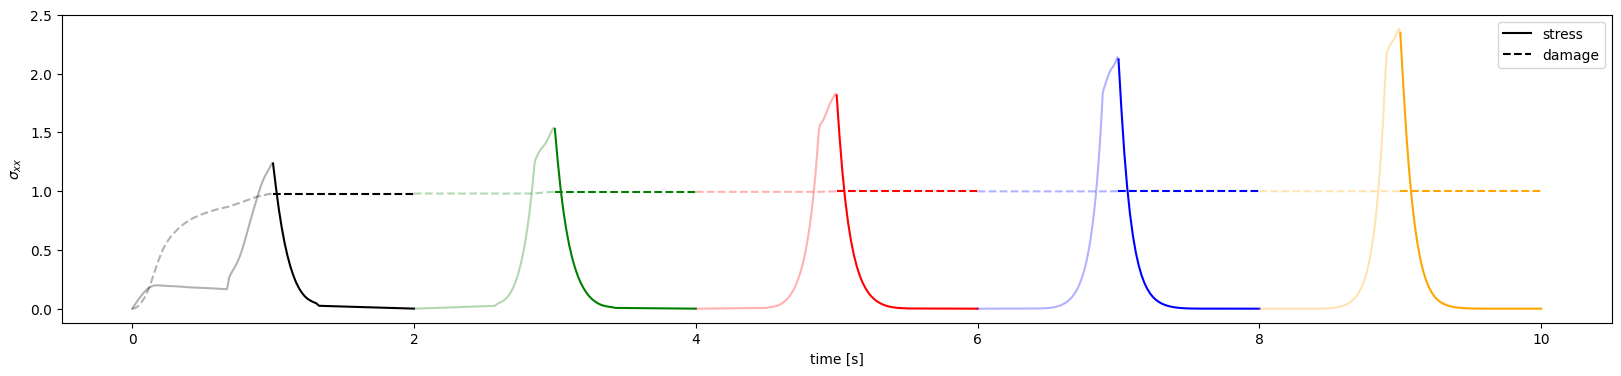

In [66]:
params = (params_Psi, params_G)
f_params = None
saveat = np.linspace(0,1.0,lmbx_l_gt.shape[1])
t, _, d = repeat_uniax(params, lmbx_max_list, ddot_vahid, saveat)
d = np.array(d)
d = np.clip(d, a_min=0.0, a_max=1.0)
fig, ax = plt.subplots(2,2,figsize=(15,12))
fig, ax2 = plt.subplots(figsize=(20,4))

cols = ['black', 'green', 'red', 'blue', 'orange']
lnstyles = ['solid', 'dashed', 'dotted', 'dashdot']

t0 = 0.0
for i in range(n_cycles):
    # Loading
    col = cols[i]
    di = d[i]
    lmbx_l = lmbx_l_gt[i]
    lmby_l = 1.0/np.sqrt(lmbx_l)
    time_l = t0 + np.linspace(0,1,lmbx_l.shape[0])
    sgmx_l = sgmx_l_gt[i]
    t0 += 1.0

    sgmx_l_pr = eval_Cauchy_vmap(lmbx_l, lmby_l, di, params)[:,0,0]

    ax[0,0].plot(time_l, lmbx_l, col)
    ax[0,1].plot(lmbx_l, sgmx_l_pr, col, linestyle='dashed', alpha=0.3)
    ax[0,1].plot(lmbx_l, sgmx_l, col, linestyle='solid', alpha=0.3)
    ax[1,0].plot(time_l, di, col)
    ax[1,1].plot(time_l, f_vmap(di, f_params), col)

    # ax[0,2].plot(time_l, sgmx_l, col, alpha=0.3)
    ax2.plot(time_l, sgmx_l_pr, col, alpha=0.3)
    ax2.plot(time_l, di, col, linestyle='dashed', alpha=0.3)

    # Unloading
    lmbx_u = np.flip(lmbx_u_gt[i])
    lmby_u = 1.0/np.sqrt(lmbx_u)
    time_u = t0 + np.linspace(0,1,lmbx_u.shape[0])
    t0 += 1
    sgmx_u = np.flip(sgmx_u_gt[i])
    sgmx_u_pr = eval_Cauchy_vmap2(lmbx_u, lmby_u, di[-1], params)[:,0,0]

    ax[0,0].plot(time_u, lmbx_u, col)
    ax[0,1].plot(lmbx_u, sgmx_u_pr, col, linestyle='dashed')
    ax[0,1].plot(lmbx_u, sgmx_u, col, linestyle='solid')
    ax[1,0].plot(time_u, di[-1]*np.ones_like(time_u), col)
    ax[1,1].plot(time_u, f_vmap(di[-1]*np.ones_like(time_u), f_params), col)

    ax2.plot(time_u, sgmx_u_pr, col)
    ax2.plot(time_u, di[-1]*np.ones_like(time_u), col, linestyle='dashed')

    sgmx_l = sgmx_l_gt[i]

ax[0,0].set(xlabel='time [s]', ylabel = '$\lambda_x$')

legend_elements = [Line2D([0], [0], color='k', linestyle= '-', label='gt'),
                   Line2D([0], [0], color='k', linestyle='--', label='pr')]
ax[0,1].legend(handles=legend_elements)
ax[0,1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$', ylim=[0,3])

legend_elements = [Line2D([0], [0], color='k', linestyle= '-', label='stress'),
                   Line2D([0], [0], color='k', linestyle='--', label='damage')]
ax2.legend(handles=legend_elements)
ax2.set(xlabel='time [s]', ylabel='$\sigma_{xx}$')

ax[1,0].set(xlabel='time [s]', ylabel='$d$')
ax[1,1].set(xlabel='time [s]', ylabel='$f(d)$')

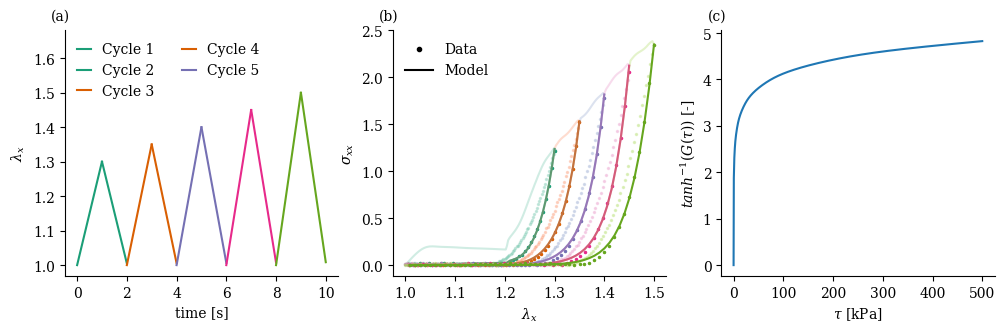

In [147]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

params = (params_Psi, params_G)
f_params = None
saveat = np.linspace(0,1.0,lmbx_l_gt.shape[1])
t, _, d = repeat_uniax(params, lmbx_max_list, ddot_vahid, saveat)
d = np.array(d)
d = np.clip(d, a_min=0.0, a_max=1.0)

resize = 0.8
n_ax = 3
fig, ax = plt.subplots(1,3,figsize=(5*n_ax*resize,4*resize))

t0 = 0.0
for i in range(n_cycles):
    # Loading
    di = d[i]
    lmbx_l = lmbx_l_gt[i]
    lmby_l = 1.0/np.sqrt(lmbx_l)
    time_l = t0 + np.linspace(0,1,lmbx_l.shape[0])
    sgmx_l = sgmx_l_gt[i]
    t0 += 1.0

    sgmx_l_pr = eval_Cauchy_vmap(lmbx_l, lmby_l, di, params)[:,0,0]

    ax[0].plot(time_l, lmbx_l, color=plt.cm.Dark2(i))
    ax[1].plot(lmbx_l, sgmx_l_pr, color=plt.cm.Set2(i), alpha=0.3)
    ax[1].plot(lmbx_l, sgmx_l, color=plt.cm.Set2(i), marker='.', alpha=0.3, lw=0, markersize=3)
    # ax[2].plot(time_l, di, color=plt.cm.Dark2(i))

    # Unloading
    lmbx_u = np.flip(lmbx_u_gt[i])
    lmby_u = 1.0/np.sqrt(lmbx_u)
    time_u = t0 + np.linspace(0,1,lmbx_u.shape[0])
    t0 += 1
    sgmx_u = np.flip(sgmx_u_gt[i])
    sgmx_u_pr = eval_Cauchy_vmap2(lmbx_u, lmby_u, di[-1], params)[:,0,0]

    ax[0].plot(time_u, lmbx_u, color=plt.cm.Dark2(i))
    ax[1].plot(lmbx_u, sgmx_u_pr, color=plt.cm.Dark2(i))
    ax[1].plot(lmbx_u, sgmx_u, color=plt.cm.Dark2(i), marker='.', lw=0, markersize=3)
    # ax[2].plot(time_u, di[-1]*np.ones_like(time_u), color=plt.cm.Dark2(i))

ax[0].set(xlabel='time [s]', ylabel = '$\lambda_x$')

legend_elements = [Line2D([0], [0], color='k', marker='.', linestyle=None, label='Data', lw=0),
                   Line2D([0], [0], color='k', linestyle='-', label='Model')]

ax[1].legend(handles=legend_elements, frameon=False)
ax[1].set(xlabel='$\lambda_x$', ylabel='$\sigma_{xx}$')
# ax[2].set(xlabel='time [s]', ylabel='$d$')

[a.spines['top'].set_visible(False)  for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
labels='abc'
for label, axi in zip(labels, ax):
    axi.text(-0.05, 1.04, '('+label+')', transform=axi.transAxes)


ax[0].plot(0, np.max(lmbx_l)*1.1, alpha=0.0)
ax[0].legend(['Cycle 1', 'Cycle 2', 'Cycle 3', 'Cycle 4', 'Cycle 5'], ncol=2, frameon=False, handlelength=1, loc='upper left')

x = np.linspace(0,500,1000)
y = vmap(G, in_axes=(0,None))(x, params_G)
y = np.arctanh(y)
ax[2].plot(x,y)
ax[2].set(xlabel='$\\tau$ [kPa]', ylabel='$tanh^{-1}(G(\\tau))$ [-]')

fig.savefig('figs/fig_derm1.pdf', bbox_inches='tight')

In [225]:
from utils_node import forward_pass_nobias, init_layers_nobias
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

def format_traj_fig(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(x=0)
    ax.set(xticks=[0,0.5,1])

In [237]:
scale = 0.3

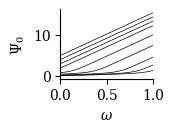

In [243]:
# Plot trajectories for the first figure
p, bias = params_Psi
y = []
for I1 in [3.15,3.2,3.3,3.5,3.84,5,6,7,8]:
    n = 100
    dt = 1.0/n
    t = np.linspace(0,1,n)
    yi = [np.array([I1-3]) + jnp.exp(bias)]
    for _ in t[1:]:
        yi.append(yi[-1] + dt*(forward_pass_nobias(yi[-1], p)) + jnp.exp(bias))
    y.append(np.array(yi))
y = np.array(y)

fig, ax = plt.subplots(figsize=(4*scale,3*scale))
for yi in y:
    ax.plot(t, yi, 'k-', linewidth=0.5)

format_traj_fig(ax)
ax.set(xlabel='$\omega$', ylabel='$\Psi_0$')
fig.savefig('figs/traj_Psi0.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

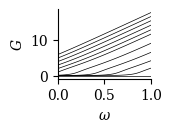

In [242]:
p, a = params_G
y = []
# for I1 in [3.15,3.2,3.3,3.5,3.84,5,6,7,8]:
for I1 in [0,0.0001,0.001, 0.01, 0.1, 1,2,3,4,5,6]:
    n = 100
    dt = 1.0/n
    t = np.linspace(0,1,n)
    yi = [np.array([I1])]
    for _ in t[1:]:
        yi.append(yi[-1] + dt*(forward_pass_nobias(yi[-1], p)))
    y.append(np.array(yi))
y = np.array(y)

fig, ax = plt.subplots(figsize=(4*scale,3*scale))
for yi in y:
    ax.plot(t, yi, 'k-', linewidth=0.5)

format_traj_fig(ax)
ax.set(xlabel='$\omega$', ylabel='$G$')
fig.savefig('figs/traj_G.pdf', bbox_inches='tight', transparent=True, pad_inches=0)

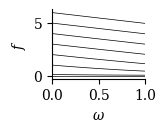

In [241]:
# key, subkey = random.split(key)
params_f = init_layers_nobias([1,3,3,3,1], key)
y = []
# for I1 in [3.15,3.2,3.3,3.5,3.84,5,6,7,8]:
for I1 in [0,0.1, 1,2,3,4,5,6]:
    n = 100
    dt = 1.0/n
    t = np.linspace(0,1,n)
    yi = [np.array([I1])]
    for _ in t[1:]:
        yi.append(yi[-1] + dt*(forward_pass_nobias(yi[-1], params_f)))
    y.append(np.array(yi))
y = np.array(y)

fig, ax = plt.subplots(figsize=(4*scale,3*scale))
for yi in y:
    ax.plot(t, yi, 'k-', linewidth=0.5)

format_traj_fig(ax)
ax.set(xlabel='$\omega$', ylabel='$f$')
fig.savefig('figs/traj_f.pdf', bbox_inches='tight', transparent=True, pad_inches=0)